# Probabilistic forecasting I: Temperature
## Kaggle Competition hosted by Carl McBride Ellis
## Catboost Multiquantiles Regression - Conformalized Quantile Regression

Submission Score: xxxxxx

### https://www.linkedin.com/in/stephane-degeye-b460a5221/

# Some Librairies

In [1]:
!pip install catboost

In [2]:
import utility_script_crps_score as us
# help(us.crps)

# Data Structure
import numpy as np
import pandas as pd

# Model
from catboost import CatBoostRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Utils
from sklearn.model_selection import train_test_split

# Error Handling
import warnings
warnings.filterwarnings("ignore")

# Plot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

%matplotlib inline

# A. Data Loading

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# # Folder related to n-beats data
# folder_id = 'kaggle/probabilistic-forecasting-i-temperature'

# # Full path
# folder_path = '/content/gdrive/My Drive/'+ folder_id

# train_df = pd.read_csv(folder_path + '/dataset/train.csv')
# kaggle_test_df = pd.read_csv(folder_path + '/dataset/test.csv')
# submission_df = pd.read_csv(folder_path + '/submission/sample_submission.csv')

In [4]:
# Load the dataset
train_df = pd.read_csv('/kaggle/input/probabilistic-forecasting-i-temperature/train_and_Public.csv')
kaggle_test_df = pd.read_csv('/kaggle/input/probabilistic-forecasting-i-temperature/test.csv')
submission_df = pd.read_csv('/kaggle/input/probabilistic-forecasting-i-temperature/sample_submission.csv')

In [5]:
train_df

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
0,0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...,...
67003,67003,2018-05-29 22:45:00,13.329,3.885,8.457,1.954,4.630,1.401,10.130000
67004,67004,2018-05-29 23:00:00,14.468,5.023,9.808,2.630,4.538,1.432,10.130000
67005,67005,2018-05-29 23:15:00,15.539,5.291,10.909,3.056,4.569,1.340,10.271000
67006,67006,2018-05-29 23:30:00,14.066,4.957,9.772,3.020,4.447,1.401,10.271000


In [6]:
kaggle_test_df

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
0,64320,2018-05-02 00:00:00,14.133,2.076,9.346,-0.036,4.538,1.279
1,64321,2018-05-02 00:15:00,12.123,1.541,7.818,-0.746,4.538,1.249
2,64322,2018-05-02 00:30:00,12.525,1.741,8.209,-0.284,4.477,1.279
3,64323,2018-05-02 00:45:00,12.324,1.942,7.747,0.249,4.630,1.371
4,64324,2018-05-02 01:00:00,14.602,1.407,9.630,-0.320,4.477,1.310
...,...,...,...,...,...,...,...,...
5355,69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462
5356,69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462
5357,69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432
5358,69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523


# B. Data Preparation

In [7]:
train_df['date'] = pd.to_datetime(train_df['date'])

In [8]:
kaggle_test_df['date'] = pd.to_datetime(kaggle_test_df['date'])

# C. Exploratory Data Analysis

## Shape of Dataframe

In [9]:
num_rec_train = train_df.shape[0]
print(f'Train dataframe contains {num_rec_train} records belongings to {round(num_rec_train / 96, 1)} days')

num_rec_test = kaggle_test_df.shape[0]
print(f'Test dataframe contains {num_rec_test} records belongings to {round(num_rec_test / 96, 1)} days')

Train dataframe contains 67008 records belongings to 698.0 days
Test dataframe contains 5360 records belongings to 55.8 days


## Missing Values

In [10]:
# Detecting missing values in train_df
missing_values = train_df.isnull().sum()

print("Missing values in each column of train_df:")
print(missing_values)

# Detecting missing values in kaggle_test_df
missing_values = kaggle_test_df.isnull().sum()

print("Missing values in each column of kaggle_test_df:")
print(missing_values)

Missing values in each column of train_df:
id             0
date           0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64
Missing values in each column of kaggle_test_df:
id            0
date          0
feature_AA    0
feature_AB    0
feature_BA    0
feature_BB    0
feature_CA    0
feature_CB    0
dtype: int64


## Tabular View

In [11]:
train_df.head()

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB,Temperature
0,0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [12]:
kaggle_test_df.head()

,id,date,feature_AA,feature_AB,feature_BA,feature_BB,feature_CA,feature_CB
0,64320,2018-05-02 00:00:00,14.133,2.076,9.346,-0.036,4.538,1.279
1,64321,2018-05-02 00:15:00,12.123,1.541,7.818,-0.746,4.538,1.249
2,64322,2018-05-02 00:30:00,12.525,1.741,8.209,-0.284,4.477,1.279
3,64323,2018-05-02 00:45:00,12.324,1.942,7.747,0.249,4.630,1.371
4,64324,2018-05-02 01:00:00,14.602,1.407,9.630,-0.320,4.477,1.310


## Data Distribution

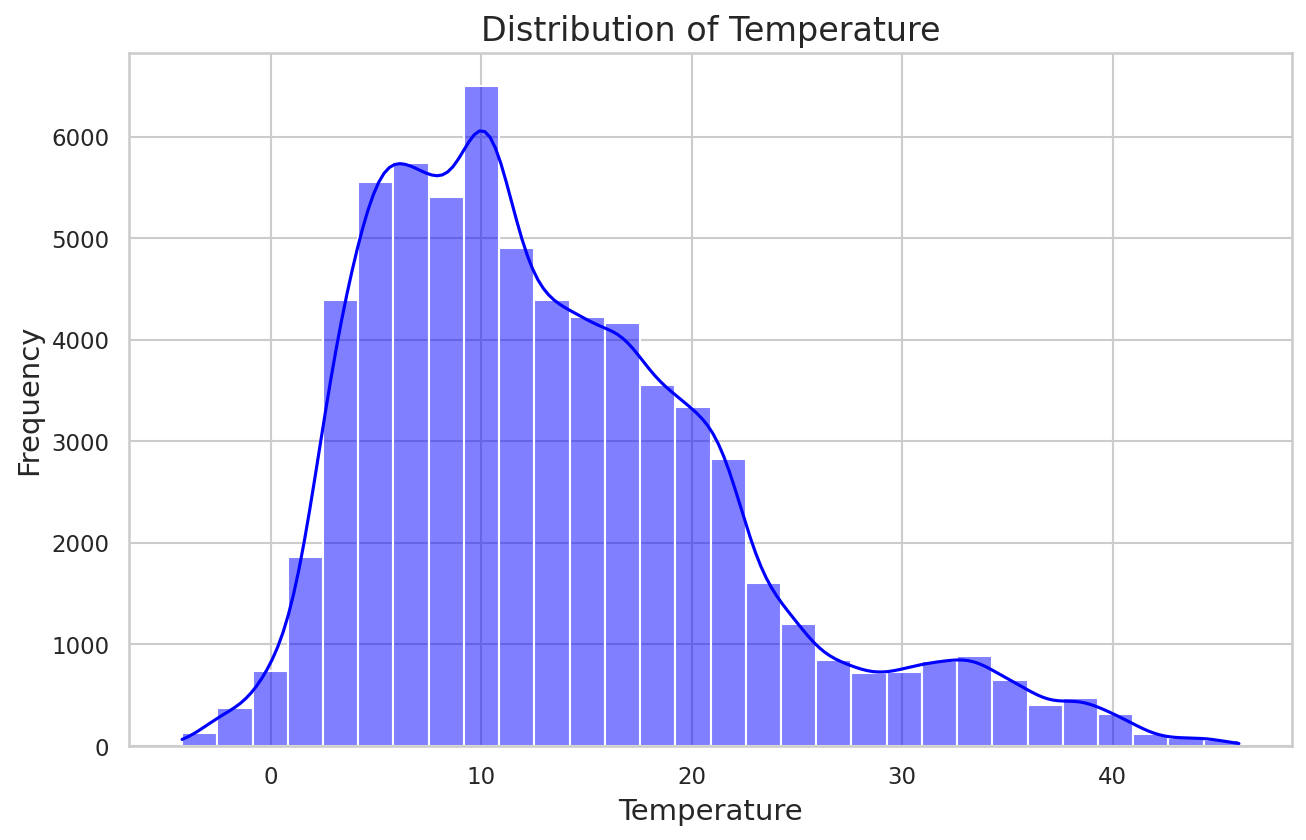

In [13]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create a histogram of the total bill
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Temperature'], bins=30, kde=True, color='blue')

# Adding titles and labels
plt.title('Distribution of Temperature', fontsize=16)
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

## Check Stationarity

In [14]:
ADF_result = adfuller(train_df['Temperature'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -4.103689681383457
p-value: 0.0009550125795118824


<div class="alert alert-block alert-danger">
<b> [Stationarity] </b> p-value < 0.05, so we can reject the Null Hypothesis, Time Series is Stationary!</div>

## Partial Autocorrelation

Text(0.5, 1.0, 'Partial Autocorrelation feature_AA')

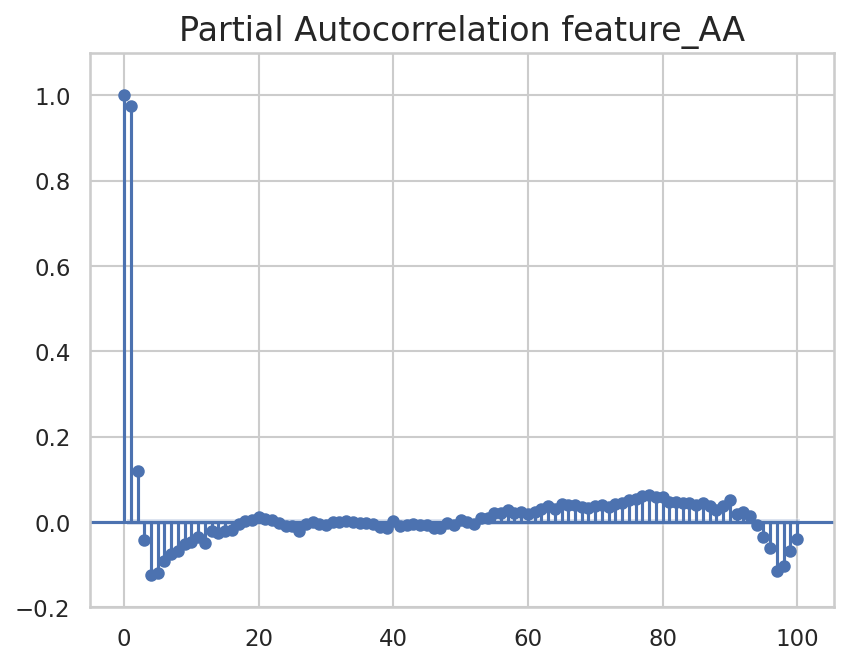

In [15]:
plot_pacf(train_df['feature_AA'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_AA', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_AB')

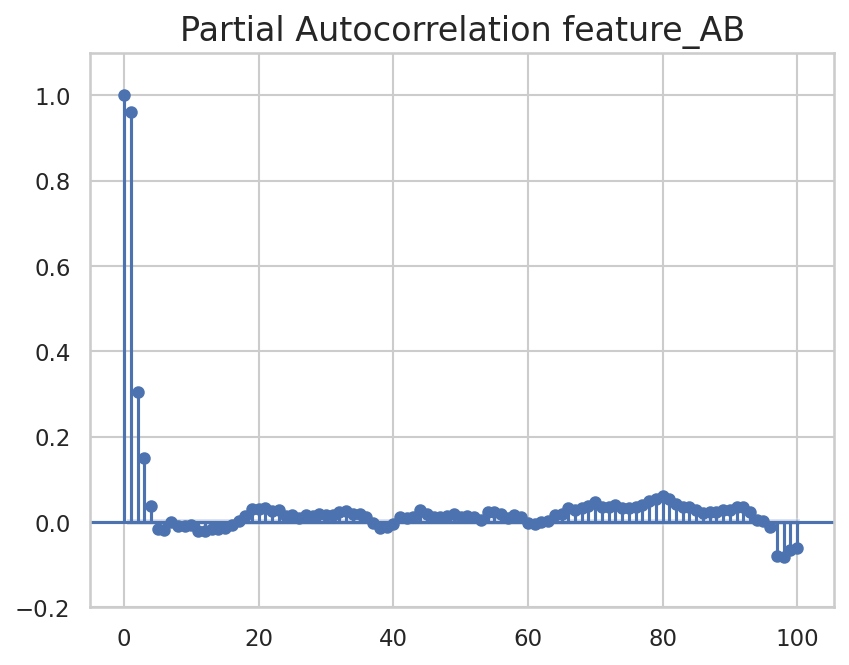

In [16]:
plot_pacf(train_df['feature_AB'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_AB', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_BA')

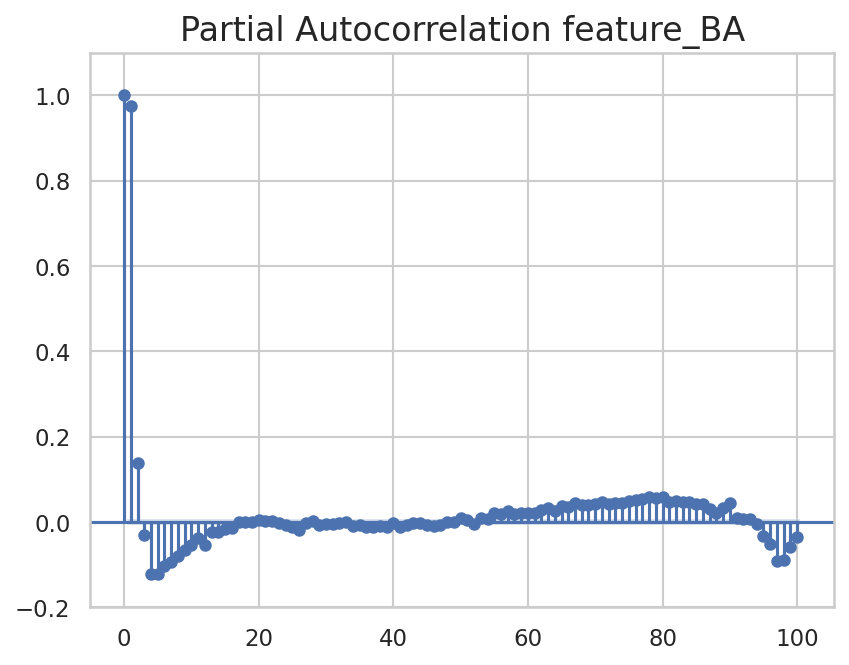

In [17]:
plot_pacf(train_df['feature_BA'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_BA', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_BB')

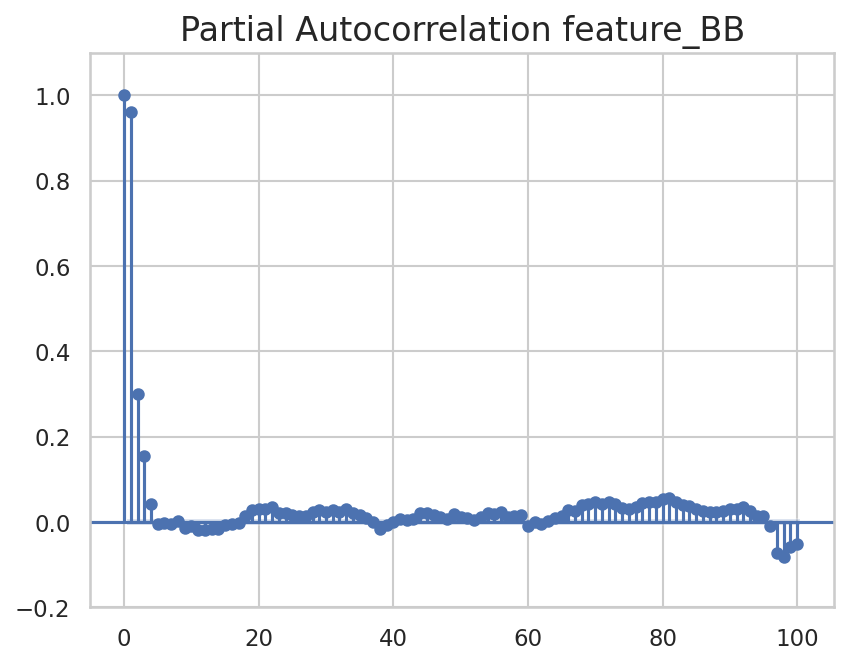

In [18]:
plot_pacf(train_df['feature_BB'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_BB', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_CA')

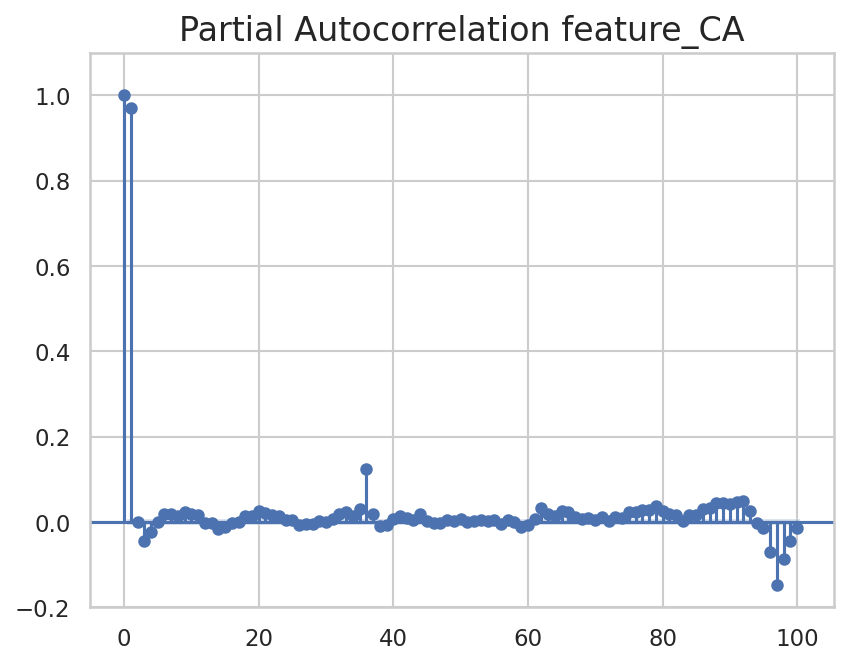

In [19]:
plot_pacf(train_df['feature_CA'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_CA', fontsize=16)

Text(0.5, 1.0, 'Partial Autocorrelation feature_CB')

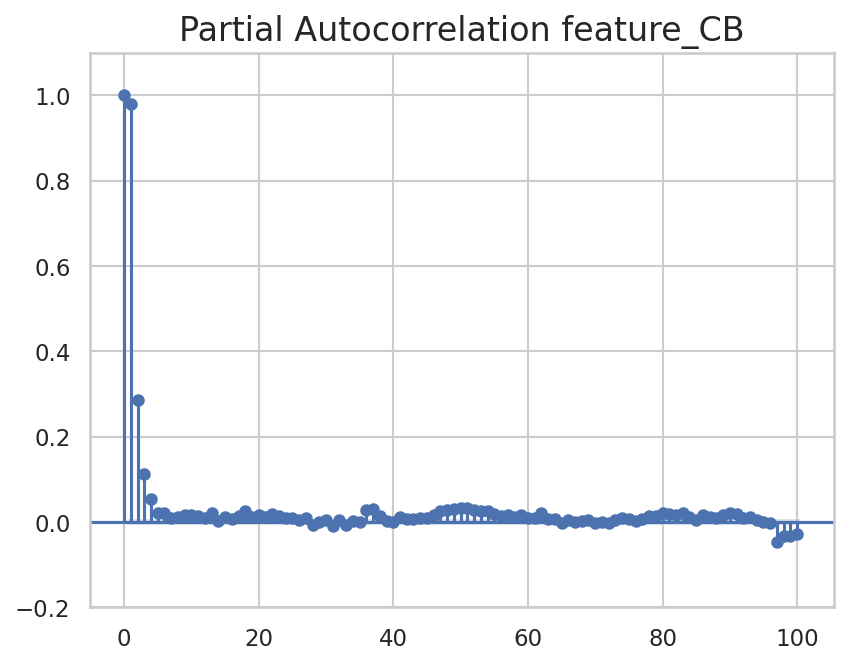

In [20]:
plot_pacf(train_df['feature_CB'], lags=100)
plt.ylim(-0.2, 1.1)
plt.tight_layout

# Adding titles and labels
plt.title('Partial Autocorrelation feature_CB', fontsize=16)

# D. Features Engineering

In [21]:
train_df['year'] = train_df['date'].dt.year.astype(int)
train_df['month'] = train_df['date'].dt.month.astype(int)
train_df['day'] = train_df['date'].dt.day.astype(int)
train_df['hour'] = train_df['date'].dt.hour.astype(int)
train_df['week_of_year'] = train_df['date'].apply(lambda x: x.isocalendar()[1])
train_df['day_of_week'] = train_df['date'].dt.dayofweek.astype(int)
train_df['id'] = train_df['id'].astype(float)

train_df['feature_AA_lag_1'] = train_df['feature_AA'].shift(1)
train_df['feature_AA_lag_2'] = train_df['feature_AA'].shift(2)
train_df['feature_AA_lag_4'] = train_df['feature_AA'].shift(4)
train_df['feature_AA_lag_5'] = train_df['feature_AA'].shift(5)
train_df['feature_AA_lag_6'] = train_df['feature_AA'].shift(6)
train_df['feature_AA_lag_97'] = train_df['feature_AA'].shift(97)
train_df['feature_AA_lag_98'] = train_df['feature_AA'].shift(98)

train_df['feature_AB_lag_1'] = train_df['feature_AB'].shift(1)
train_df['feature_AB_lag_2'] = train_df['feature_AB'].shift(2)
train_df['feature_AB_lag_3'] = train_df['feature_AB'].shift(3)
train_df['feature_AB_lag_98'] = train_df['feature_AB'].shift(98)

train_df['feature_CA_lag_1'] = train_df['feature_CA'].shift(1)
train_df['feature_CA_lag_36'] = train_df['feature_CA'].shift(36)
train_df['feature_CA_lag_97'] = train_df['feature_CA'].shift(97)
train_df['feature_CA_lag_98'] = train_df['feature_CA'].shift(98)

train_df['feature_CB_lag_1'] = train_df['feature_CB'].shift(1)
train_df['feature_CB_lag_2'] = train_df['feature_CB'].shift(2)
train_df['feature_CB_lag_3'] = train_df['feature_CB'].shift(3)

# Create Fourier terms for dayly seasonality
train_fourier_day = np.sin(2 * np.pi * np.arange(len(train_df)) / 96)
train_fourier_day += np.cos(2 * np.pi * np.arange(len(train_df)) / 96)
train_df['fourier_terms_day'] = train_fourier_day

# Create Fourier terms for weekly seasonality
train_fourier_week = np.sin(2 * np.pi * np.arange(len(train_df)) / 96*7)
train_fourier_week += np.cos(2 * np.pi * np.arange(len(train_df)) / 96*7)
train_df['fourier_terms_week'] = train_fourier_week

train_df.drop('feature_BA', axis=1, inplace=True)
train_df.drop('feature_BB', axis=1, inplace=True)
train_df.drop('date', axis=1, inplace=True)

kaggle_test_df['year'] = kaggle_test_df['date'].dt.year.astype(int)
kaggle_test_df['month'] = kaggle_test_df['date'].dt.month.astype(int)
kaggle_test_df['day'] = kaggle_test_df['date'].dt.day.astype(int)
kaggle_test_df['hour'] = kaggle_test_df['date'].dt.hour.astype(int)
kaggle_test_df['week_of_year'] = kaggle_test_df['date'].apply(lambda x: x.isocalendar()[1])
kaggle_test_df['day_of_week'] = kaggle_test_df['date'].dt.dayofweek.astype(int)
kaggle_test_df['id'] = kaggle_test_df['id'].astype(float)

kaggle_test_df['feature_AA_lag_1'] = kaggle_test_df['feature_AA'].shift(1)
kaggle_test_df['feature_AA_lag_2'] = kaggle_test_df['feature_AA'].shift(2)
kaggle_test_df['feature_AA_lag_4'] = kaggle_test_df['feature_AA'].shift(4)
kaggle_test_df['feature_AA_lag_5'] = kaggle_test_df['feature_AA'].shift(5)
kaggle_test_df['feature_AA_lag_6'] = kaggle_test_df['feature_AA'].shift(6)
kaggle_test_df['feature_AA_lag_97'] = kaggle_test_df['feature_AA'].shift(97)
kaggle_test_df['feature_AA_lag_98'] = kaggle_test_df['feature_AA'].shift(98)

kaggle_test_df['feature_AB_lag_1'] = kaggle_test_df['feature_AB'].shift(1)
kaggle_test_df['feature_AB_lag_2'] = kaggle_test_df['feature_AB'].shift(2)
kaggle_test_df['feature_AB_lag_3'] = kaggle_test_df['feature_AB'].shift(3)
kaggle_test_df['feature_AB_lag_98'] = kaggle_test_df['feature_AB'].shift(98)

kaggle_test_df['feature_CA_lag_1'] = kaggle_test_df['feature_CA'].shift(1)
kaggle_test_df['feature_CA_lag_36'] = kaggle_test_df['feature_CA'].shift(36)
kaggle_test_df['feature_CA_lag_97'] = kaggle_test_df['feature_CA'].shift(97)
kaggle_test_df['feature_CA_lag_98'] = kaggle_test_df['feature_CA'].shift(98)

kaggle_test_df['feature_CB_lag_1'] = kaggle_test_df['feature_CB'].shift(1)
kaggle_test_df['feature_CB_lag_2'] = kaggle_test_df['feature_CB'].shift(2)
kaggle_test_df['feature_CB_lag_3'] = kaggle_test_df['feature_CB'].shift(3)


# Create Fourier terms for dayly seasonality
kaggle_test_fourier_day = np.sin(2 * np.pi * np.arange(len(kaggle_test_df)) / 96)
kaggle_test_fourier_day += np.cos(2 * np.pi * np.arange(len(kaggle_test_df)) / 96)
kaggle_test_df['fourier_terms_day'] = kaggle_test_fourier_day

# Create Fourier terms for weekly seasonality
kaggle_test_fourier_week = np.sin(2 * np.pi * np.arange(len(kaggle_test_df)) / 96*7)
kaggle_test_fourier_week += np.cos(2 * np.pi * np.arange(len(kaggle_test_df)) / 96*7)
kaggle_test_df['fourier_terms_week'] = kaggle_test_fourier_week

kaggle_test_df.drop('feature_BA', axis=1, inplace=True)
kaggle_test_df.drop('feature_BB', axis=1, inplace=True)
kaggle_test_df.drop('date', axis=1, inplace=True)

In [22]:
train_df

,id,feature_AA,feature_AB,feature_CA,feature_CB,Temperature,year,month,day,hour,...,feature_AB_lag_98,feature_CA_lag_1,feature_CA_lag_36,feature_CA_lag_97,feature_CA_lag_98,feature_CB_lag_1,feature_CB_lag_2,feature_CB_lag_3,fourier_terms_day,fourier_terms_week
0,0.0,5.827,2.009,4.203,1.340,30.531000,2016,7,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
1,1.0,5.760,2.076,4.264,1.401,30.459999,2016,7,1,0,...,NaN,4.203,NaN,NaN,NaN,1.340,NaN,NaN,1.063262,1.339161
2,2.0,5.760,1.942,4.234,1.310,30.038000,2016,7,1,0,...,NaN,4.264,NaN,NaN,NaN,1.401,1.340,NaN,1.121971,1.402115
3,3.0,5.760,1.942,4.234,1.310,27.013000,2016,7,1,0,...,NaN,4.234,NaN,NaN,NaN,1.310,1.401,1.340,1.175876,1.175876
4,4.0,5.693,2.076,4.142,1.371,27.787001,2016,7,1,1,...,NaN,4.234,NaN,NaN,NaN,1.310,1.310,1.401,1.224745,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67003,67003.0,13.329,3.885,4.630,1.401,10.130000,2018,5,29,22,...,4.287,4.752,2.559,4.569,4.630,1.340,1.432,1.066,0.625491,-1.411186
67004,67004.0,14.468,5.023,4.538,1.432,10.130000,2018,5,29,23,...,4.689,4.630,2.711,4.508,4.569,1.401,1.340,1.432,0.707107,-1.224745
67005,67005.0,15.539,5.291,4.569,1.340,10.271000,2018,5,29,23,...,4.488,4.538,2.680,4.386,4.508,1.432,1.401,1.340,0.785695,-0.785695
67006,67006.0,14.066,4.957,4.447,1.401,10.271000,2018,5,29,23,...,5.224,4.569,2.711,4.325,4.386,1.340,1.432,1.401,0.860919,-0.184592


In [23]:
kaggle_test_df

,id,feature_AA,feature_AB,feature_CA,feature_CB,year,month,day,hour,week_of_year,...,feature_AB_lag_98,feature_CA_lag_1,feature_CA_lag_36,feature_CA_lag_97,feature_CA_lag_98,feature_CB_lag_1,feature_CB_lag_2,feature_CB_lag_3,fourier_terms_day,fourier_terms_week
0,64320.0,14.133,2.076,4.538,1.279,2018,5,2,0,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
1,64321.0,12.123,1.541,4.538,1.249,2018,5,2,0,18,...,NaN,4.538,NaN,NaN,NaN,1.279,NaN,NaN,1.063262,1.339161
2,64322.0,12.525,1.741,4.477,1.279,2018,5,2,0,18,...,NaN,4.538,NaN,NaN,NaN,1.249,1.279,NaN,1.121971,1.402115
3,64323.0,12.324,1.942,4.630,1.371,2018,5,2,0,18,...,NaN,4.477,NaN,NaN,NaN,1.279,1.249,1.279,1.175876,1.175876
4,64324.0,14.602,1.407,4.477,1.310,2018,5,2,1,18,...,NaN,4.630,NaN,NaN,NaN,1.371,1.279,1.249,1.224745,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675.0,9.310,3.550,3.868,1.462,2018,6,26,18,26,...,3.215,3.746,3.503,3.320,3.290,1.492,1.371,1.432,-0.785695,-0.785695
5356,69676.0,10.114,3.550,3.716,1.462,2018,6,26,19,26,...,3.081,3.868,3.564,3.350,3.320,1.462,1.492,1.371,-0.707107,-1.224745
5357,69677.0,10.784,3.349,3.746,1.432,2018,6,26,19,26,...,2.813,3.716,3.868,3.320,3.350,1.462,1.462,1.492,-0.625491,-1.411186
5358,69678.0,11.655,3.617,4.173,1.523,2018,6,26,19,26,...,2.813,3.746,3.533,3.716,3.320,1.432,1.462,1.462,-0.541196,-1.306563


## Pearson Pairwise Correlation

In [24]:
pear_corr = train_df.drop(['id'], axis=1).corr(method='pearson')
pear_corr.style.background_gradient(cmap='Greens', axis=0)

,feature_AA,feature_AB,feature_CA,feature_CB,Temperature,year,month,day,hour,week_of_year,day_of_week,feature_AA_lag_1,feature_AA_lag_2,feature_AA_lag_4,feature_AA_lag_5,feature_AA_lag_6,feature_AA_lag_97,feature_AA_lag_98,feature_AB_lag_1,feature_AB_lag_2,feature_AB_lag_3,feature_AB_lag_98,feature_CA_lag_1,feature_CA_lag_36,feature_CA_lag_97,feature_CA_lag_98,feature_CB_lag_1,feature_CB_lag_2,feature_CB_lag_3,fourier_terms_day,fourier_terms_week
feature_AA,1.000000,0.122063,0.294185,0.033516,0.063114,-0.157987,0.044273,0.044876,-0.117455,0.049104,0.002357,0.976227,0.958601,0.913788,0.885304,0.854096,0.789483,0.779302,0.111644,0.101353,0.092188,0.092336,0.282314,0.098370,0.200050,0.188968,0.027440,0.021572,0.015963,0.505168,0.022900
feature_AB,0.122063,1.000000,0.242555,0.352234,0.251134,-0.135263,0.248843,0.050730,-0.232794,0.246125,0.018866,0.128399,0.135410,0.151034,0.158829,0.167848,0.110330,0.117282,0.960662,0.946376,0.935381,0.802605,0.237369,0.109820,0.149467,0.146596,0.346969,0.341883,0.336353,0.193589,0.022131
feature_CA,0.294185,0.242555,1.000000,0.323866,0.133640,0.153328,-0.119545,0.106054,0.014994,-0.109129,0.006837,0.294092,0.291186,0.279448,0.271422,0.263208,0.214635,0.214809,0.238446,0.233669,0.229084,0.167617,0.970908,0.431591,0.579805,0.568457,0.312048,0.301083,0.291087,0.009290,0.051838
feature_CB,0.033516,0.352234,0.323866,1.000000,0.087059,0.076730,-0.050836,0.032741,-0.041703,-0.046628,0.012497,0.035981,0.038892,0.044943,0.047754,0.050855,-0.000267,0.003629,0.352120,0.352015,0.351303,0.287160,0.312523,0.135050,0.143561,0.142534,0.980636,0.972662,0.965464,-0.037838,0.013183
Temperature,0.063114,0.251134,0.133640,0.087059,1.000000,-0.606526,0.234547,0.003515,0.049383,0.227676,0.015562,0.059311,0.055817,0.049696,0.047153,0.044955,0.058681,0.055770,0.252928,0.254659,0.256358,0.243037,0.133603,0.145556,0.116721,0.116652,0.087915,0.088646,0.089358,-0.081548,0.003780
year,-0.157987,-0.135263,0.153328,0.076730,-0.606526,1.000000,-0.633153,-0.015855,-0.000000,-0.627706,-0.008256,-0.157975,-0.157961,-0.157940,-0.157924,-0.157911,-0.155126,-0.155109,-0.135295,-0.135321,-0.135352,-0.136792,0.153317,0.153924,0.154499,0.154497,0.076705,0.076688,0.076673,0.000000,0.000000
month,0.044273,0.248843,-0.119545,-0.050836,0.234547,-0.633153,1.000000,0.014153,-0.000000,0.988954,0.013087,0.044252,0.044231,0.044184,0.044156,0.044129,0.039766,0.039739,0.248856,0.248861,0.248869,0.248002,-0.119576,-0.120778,-0.122298,-0.122321,-0.050849,-0.050865,-0.050878,0.000000,-0.000000
day,0.044876,0.050730,0.106054,0.032741,0.003515,-0.015855,0.014153,1.000000,0.000000,0.087790,-0.008205,0.044885,0.044917,0.044810,0.044730,0.044643,-0.005620,-0.005632,0.050897,0.051119,0.051286,0.044708,0.106125,0.106379,0.097464,0.097408,0.032846,0.032973,0.033119,0.000000,0.000000
hour,-0.117455,-0.232794,0.014994,-0.041703,0.049383,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.141879,-0.166630,-0.209705,-0.228711,-0.247925,-0.141641,-0.166383,-0.246035,-0.258712,-0.269712,-0.258445,0.012537,-0.027012,0.013056,0.009019,-0.040163,-0.038917,-0.039093,-0.569669,-0.095504
week_of_year,0.049104,0.246125,-0.109129,-0.046628,0.227676,-0.627706,0.988954,0.087790,-0.000000,1.000000,0.000906,0.049122,0.049143,0.049167,0.049167,0.049167,0.042649,0.042625,0.246197,0.246263,0.246331,0.247543,-0.109111,-0.110679,-0.117080,-0.117108,-0.046596,-0.046566,-0.046532,0.000000,-0.000000


# E. Modeling

## Hyperparameters

In [25]:
quantile_mapping = {
    95: ['0.025', '0.975'],
    90: ['0.05', '0.95'],
    80: ['0.10', '0.90'],
    70: ['0.15', '0.85'],
    60: ['0.20', '0.80'],
    50: ['0.25', '0.75'],
    40: ['0.30', '0.70'],
    30: ['0.35', '0.65'],
    20: ['0.40', '0.60'],
    10: ['0.45', '0.55']
}

In [26]:
quantiles = [0.025, 0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975]
levels = np.array([95, 90, 80, 70, 60, 50, 40, 30, 20, 10])

In [27]:
quantile_str = str(quantiles).replace('[','').replace(']','')

In [28]:
submission_val_df = submission_df[:5360].copy()

## Dataset Splitting

In [29]:
X = train_df.drop('Temperature', axis=1)
y = train_df['Temperature']

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=5360)

In [31]:
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

## Model Definition

In [32]:
# model definition
multiquantiles_model = CatBoostRegressor(
                                        loss_function = f'MultiQuantile:alpha={quantile_str}',
                                        thread_count = -1,
                                        bootstrap_type =  "Bernoulli",
                                        sampling_frequency= 'PerTree',
                                        iterations = 10000,
                                     **{'learning_rate': 0.015,
                                          'max_depth': 10,
                                          'subsample': 0.75,
                                          'colsample_bylevel': 0.9,
                                          'min_data_in_leaf': 37},
                                           verbose=1000
                              )


# model fitting on training set
multiquantiles_model.fit(X_proper_train, y_proper_train, eval_set=(X_val, y_val))

0:	learn: 2.2749846	test: 2.3136546	best: 2.3136546 (0)	total: 1.61s	remaining: 4h 28m 15s
1000:	learn: 0.3242951	test: 0.3526926	best: 0.3526926 (1000)	total: 26m 8s	remaining: 3h 54m 56s
2000:	learn: 0.2298933	test: 0.2727583	best: 0.2727583 (2000)	total: 52m 12s	remaining: 3h 28m 42s
3000:	learn: 0.1868970	test: 0.2432598	best: 0.2432598 (3000)	total: 1h 18m 20s	remaining: 3h 2m 42s
4000:	learn: 0.1615012	test: 0.2299190	best: 0.2299190 (4000)	total: 1h 44m 34s	remaining: 2h 36m 47s
5000:	learn: 0.1448078	test: 0.2235975	best: 0.2235923 (4995)	total: 2h 10m 49s	remaining: 2h 10m 46s
6000:	learn: 0.1329379	test: 0.2203475	best: 0.2203262 (5987)	total: 2h 37m	remaining: 1h 44m 37s
7000:	learn: 0.1229502	test: 0.2184948	best: 0.2184948 (7000)	total: 3h 3m 12s	remaining: 1h 18m 28s
8000:	learn: 0.1153470	test: 0.2177460	best: 0.2177409 (7999)	total: 3h 29m 26s	remaining: 52m 19s
9000:	learn: 0.1095741	test: 0.2177359	best: 0.2177078 (8567)	total: 3h 55m 32s	remaining: 26m 8s
9999:	learn

## Predictions

In [33]:
predict_cal = multiquantiles_model.predict(X_cal)
predict_val = multiquantiles_model.predict(X_val)
predict_test = multiquantiles_model.predict(kaggle_test_df)

# F. Conformalized Quantile Regression (CQR)

level : 95 interval : [0.025 , 0.975]



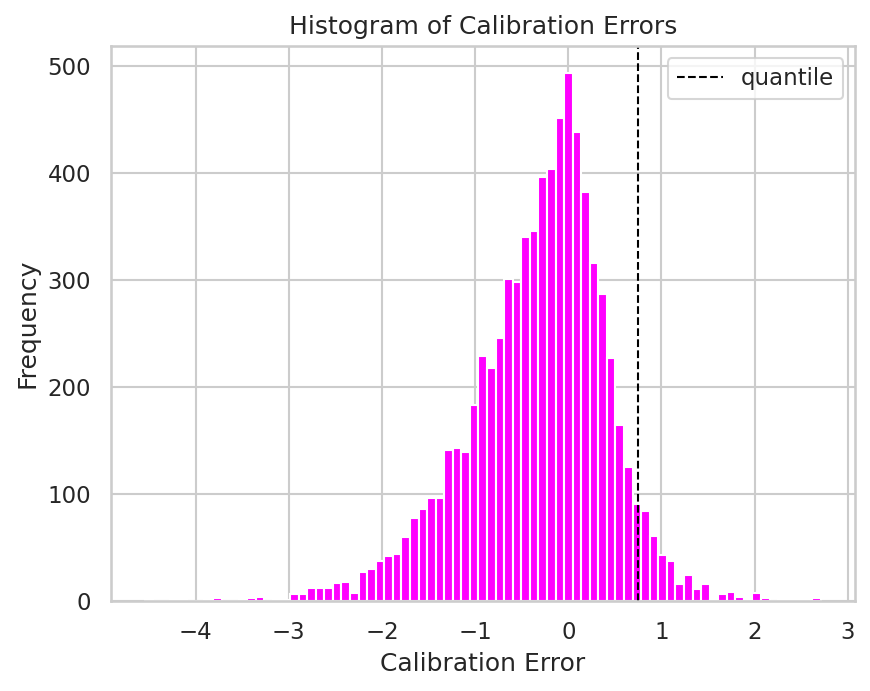

level : 90 interval : [0.05 , 0.95]



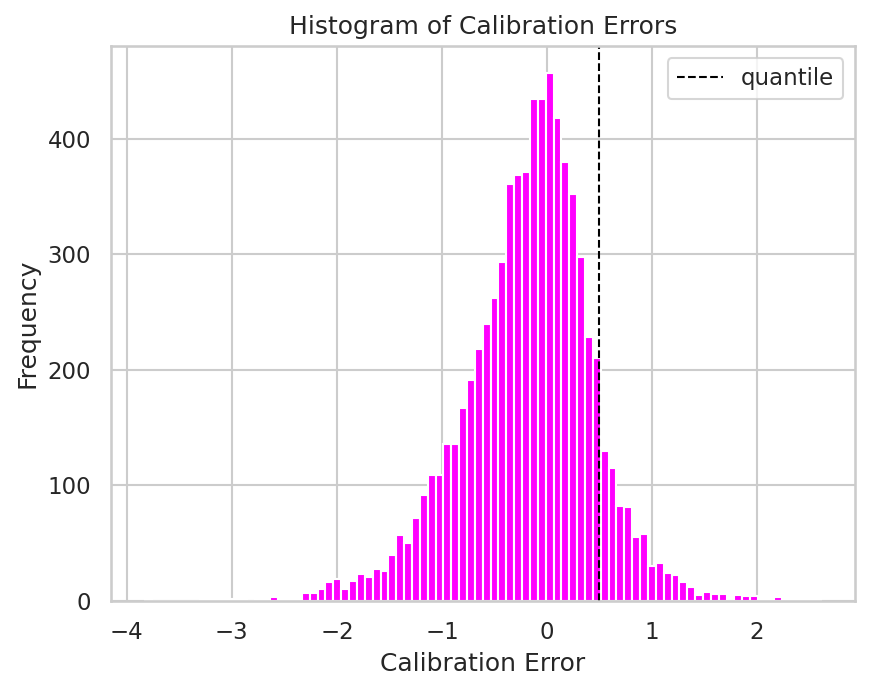

level : 80 interval : [0.10 , 0.90]



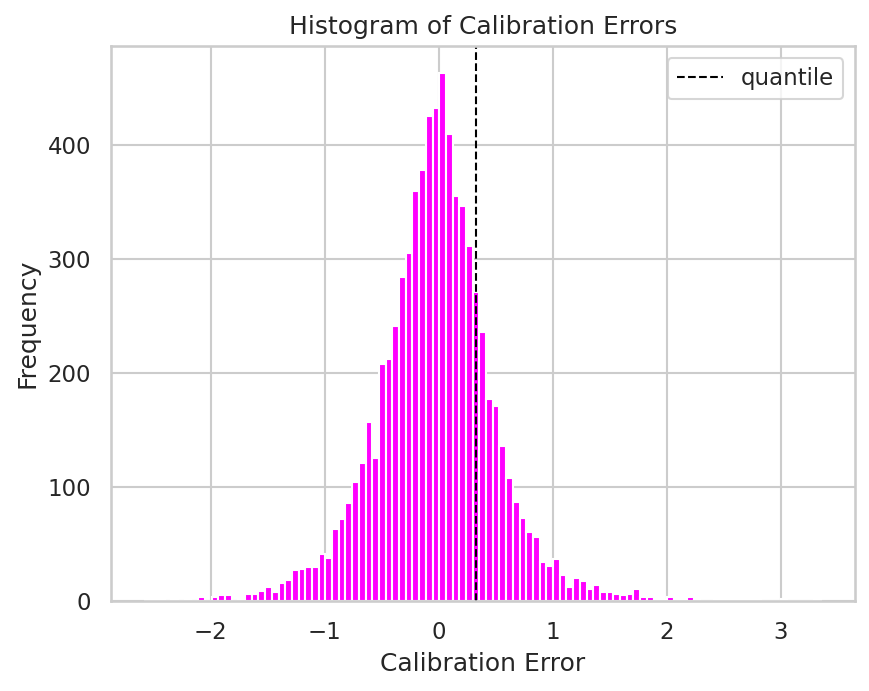

level : 70 interval : [0.15 , 0.85]



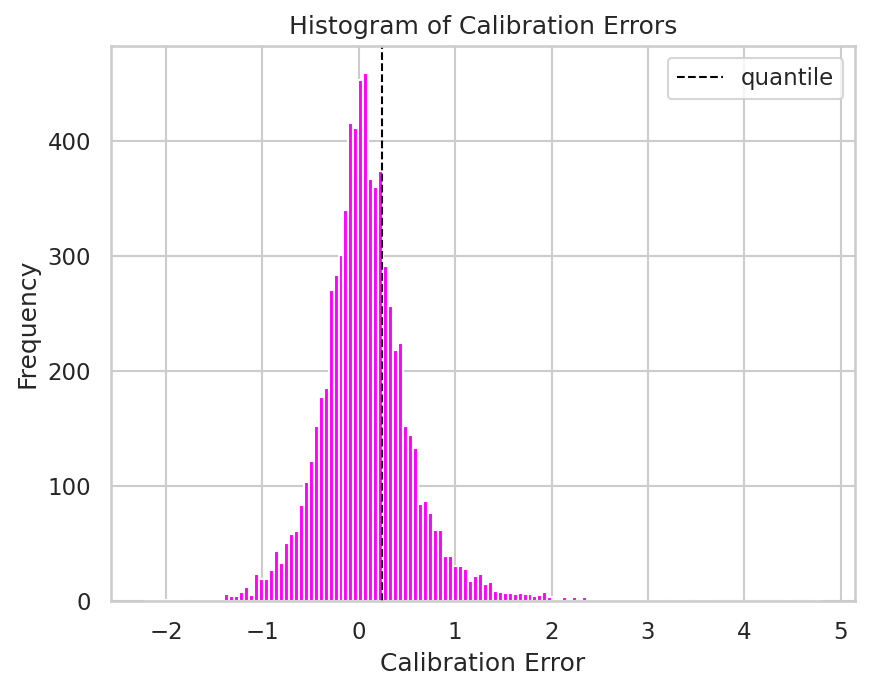

level : 60 interval : [0.20 , 0.80]



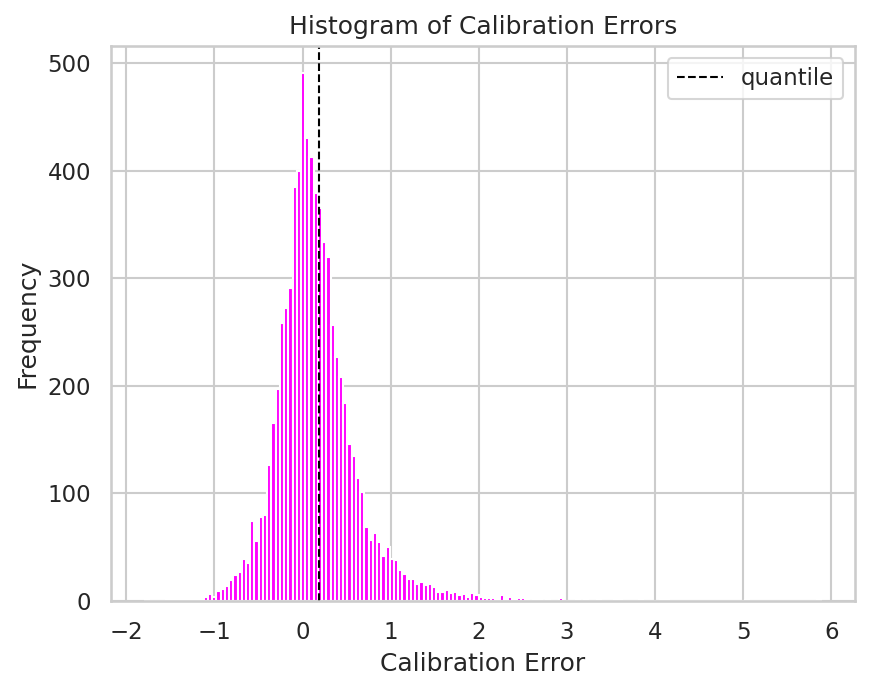

level : 50 interval : [0.25 , 0.75]



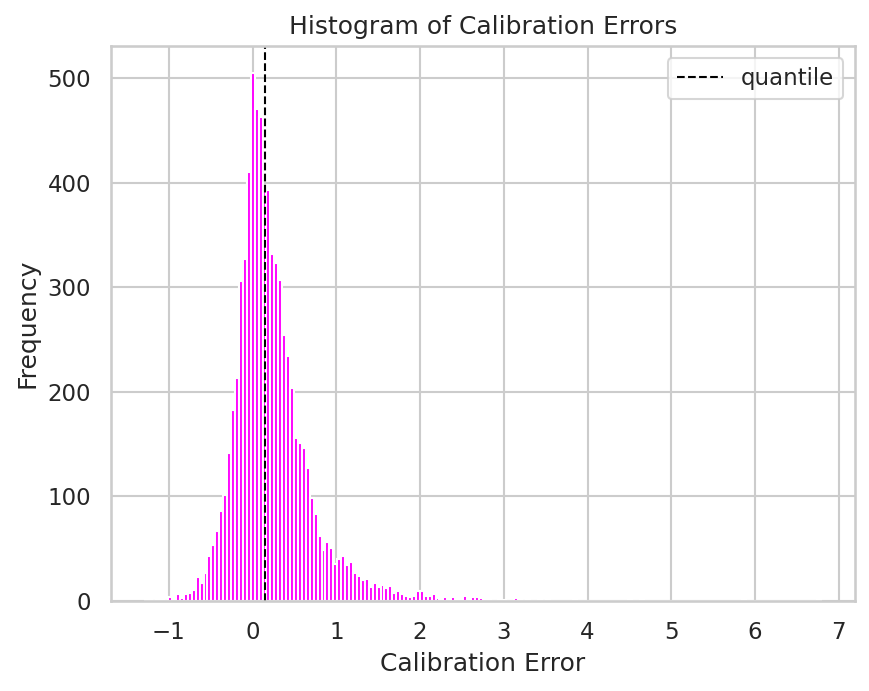

level : 40 interval : [0.30 , 0.70]



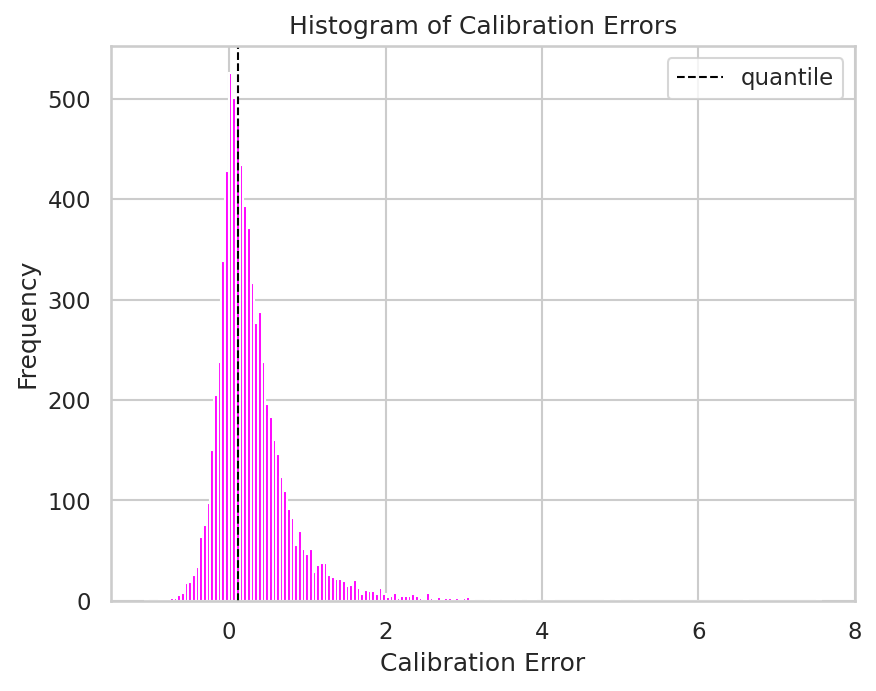

level : 30 interval : [0.35 , 0.65]



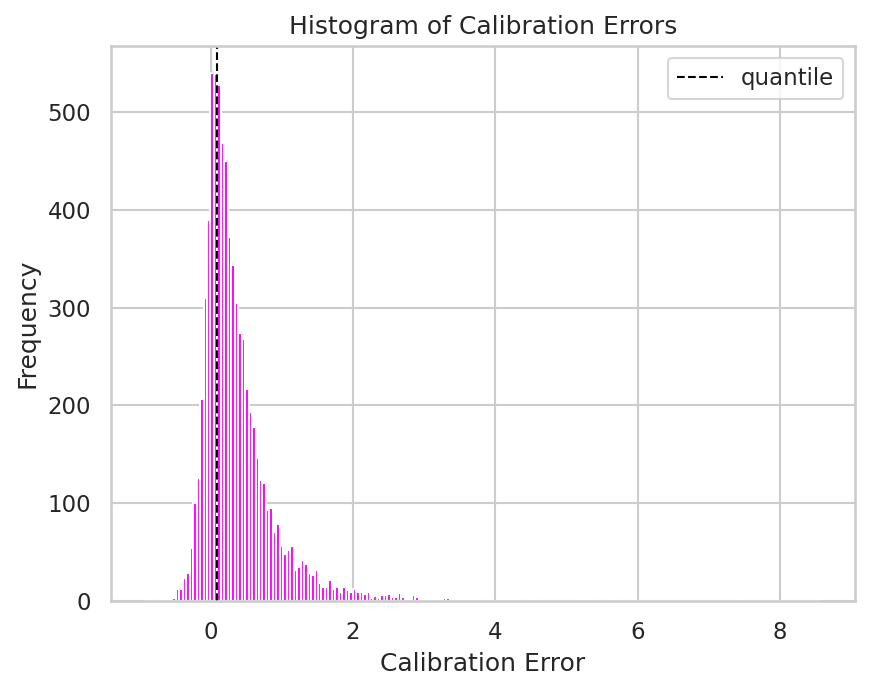

level : 20 interval : [0.40 , 0.60]



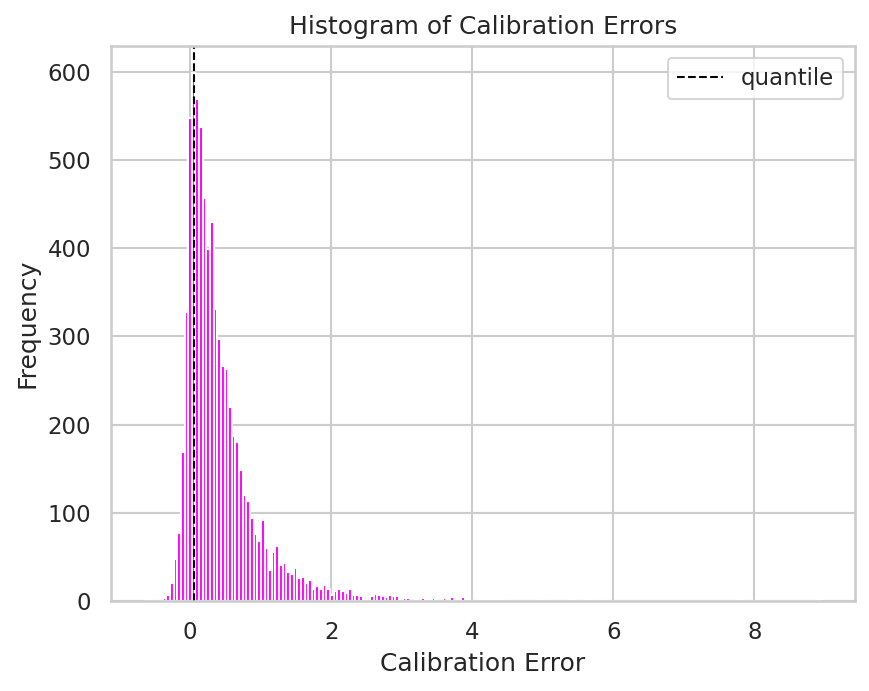

level : 10 interval : [0.45 , 0.55]



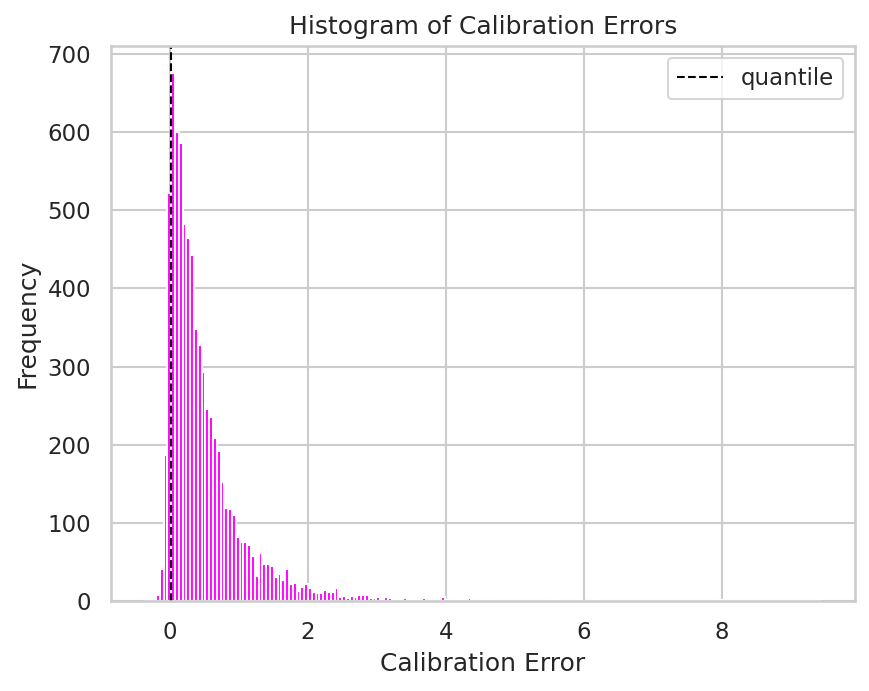

In [34]:
for index, (level, q_pair) in enumerate(quantile_mapping.items()):

    print(f'level : {level} interval : [{q_pair[0]} , {q_pair[1]}]\n')

    quantile_regression_calibration_intervals = np.zeros([len(X_cal), 2])
    quantile_regression_calibration_intervals[:, 0] = predict_cal[:, index]
    quantile_regression_calibration_intervals[:, 1] = predict_cal[:, 20 - index]

    conformity_scores = np.max(
    [
        quantile_regression_calibration_intervals[:, 0] - y_cal,
        y_cal - quantile_regression_calibration_intervals[:, 1],
    ],
    axis=0,
    )

    conformity_scores = np.sort(conformity_scores)[::-1]
    
    emperical_quantile = (level/100) * (1 + (1 / len(y_cal)))
    correction_factor = np.quantile(conformity_scores, emperical_quantile, method="higher")
    
    # Plot the histogram
    plt.hist(conformity_scores, bins='auto', color='magenta')

    # Add a vertical line for the
    plt.axvline(correction_factor, color='black', linestyle='dashed', linewidth=1, label='quantile')

    plt.legend()
    plt.xlabel('Calibration Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Calibration Errors')

    plt.show()

    quantile_regression_prediction_intervals_kaggle = np.zeros([len(kaggle_test_df), 2])
    quantile_regression_prediction_intervals_kaggle[:, 0] = predict_test[:, index]
    quantile_regression_prediction_intervals_kaggle[:, 1] = predict_test[:, 20 - index]

    correction_factor_kaggle = np.ones([len(kaggle_test_df), 2])
    correction_factor_kaggle[:, 0] = correction_factor_kaggle[:, 0] * correction_factor * -1
    correction_factor_kaggle[:, 1] = correction_factor_kaggle[:, 1] * correction_factor

    quantile_regression_prediction_intervals_validation = np.zeros([len(X_val), 2])
    quantile_regression_prediction_intervals_validation[:, 0] = predict_val[:, index]
    quantile_regression_prediction_intervals_validation[:, 1] = predict_val[:, 20 - index]

    correction_factor_validation = np.ones([len(X_val), 2])
    correction_factor_validation[:, 0] = correction_factor_validation[:, 0] * correction_factor * -1
    correction_factor_validation[:, 1] = correction_factor_validation[:, 1] * correction_factor

    submission_df[q_pair[0]] = quantile_regression_prediction_intervals_kaggle[:, 0] + correction_factor_kaggle[:, 0]
    submission_df[q_pair[1]] = quantile_regression_prediction_intervals_kaggle[:, 1] + correction_factor_kaggle[:, 1]

    submission_val_df[q_pair[0]] = quantile_regression_prediction_intervals_validation[:, 0] + correction_factor_validation[:, 0]
    submission_val_df[q_pair[1]] = quantile_regression_prediction_intervals_validation[:, 1] + correction_factor_validation[:, 1]

In [35]:
## Median
submission_df['0.50'] = predict_test[:, 10]
submission_val_df['0.50'] = predict_val[:, 10]

In [36]:
submission_df

,id,0.025,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,0.975
0,64320,17.118597,14.766495,12.219985,10.913882,10.000016,9.179826,8.906405,9.196717,8.529288,...,8.121347,7.494214,6.976346,6.902980,6.256169,5.805042,5.118874,4.522659,3.718383,2.616479
1,64321,16.822763,14.566397,12.155772,11.042812,9.986718,9.191930,8.920287,8.948185,8.282838,...,7.965923,7.469712,6.966637,6.933814,6.303350,5.937150,5.202981,4.532935,3.740325,2.804353
2,64322,17.965744,15.629186,13.029063,11.769344,10.518191,9.530502,9.259636,9.108515,8.384406,...,7.657915,7.104995,6.570100,6.413274,5.676979,5.132586,4.274635,3.055415,1.820729,0.626068
3,64323,16.723264,14.772995,12.550072,11.389146,10.389588,9.490754,9.357465,9.194122,8.470590,...,7.782267,7.215260,6.812372,6.535414,5.924273,5.480022,4.630497,3.545770,2.391543,1.556771
4,64324,16.762009,14.802696,12.560035,11.343726,10.228325,9.379485,9.127987,8.885902,8.181055,...,7.752715,7.244166,6.836294,6.677007,6.099481,5.634659,4.903898,3.823909,2.642168,1.788172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,69675,8.994873,9.672954,10.033574,10.192549,10.245882,10.420507,10.558773,10.676593,10.771432,...,10.957272,11.020297,11.084128,11.149620,11.198339,11.302102,11.409740,11.674091,11.949554,12.145882
5356,69676,8.789226,9.455807,9.804010,9.974341,10.055545,10.132220,10.177842,10.210683,10.283743,...,10.523054,10.556371,10.637179,10.701140,10.753299,10.984049,11.092541,11.344591,11.622963,11.821484
5357,69677,8.792123,9.343339,9.686042,9.823166,9.924738,9.973015,9.951389,9.992483,10.033445,...,10.170374,10.207441,10.289661,10.407768,10.467243,10.630791,10.779627,11.015016,11.300625,11.573941
5358,69678,8.450279,8.974804,9.368612,9.521465,9.685379,9.749861,9.863075,9.897426,9.932459,...,10.058632,10.060302,10.104843,10.155585,10.195181,10.381753,10.523788,10.733121,11.023016,11.313971


# G. Prediction Interval (PI) Visualization

level : 95 interval : [0.025 , 0.975 ]



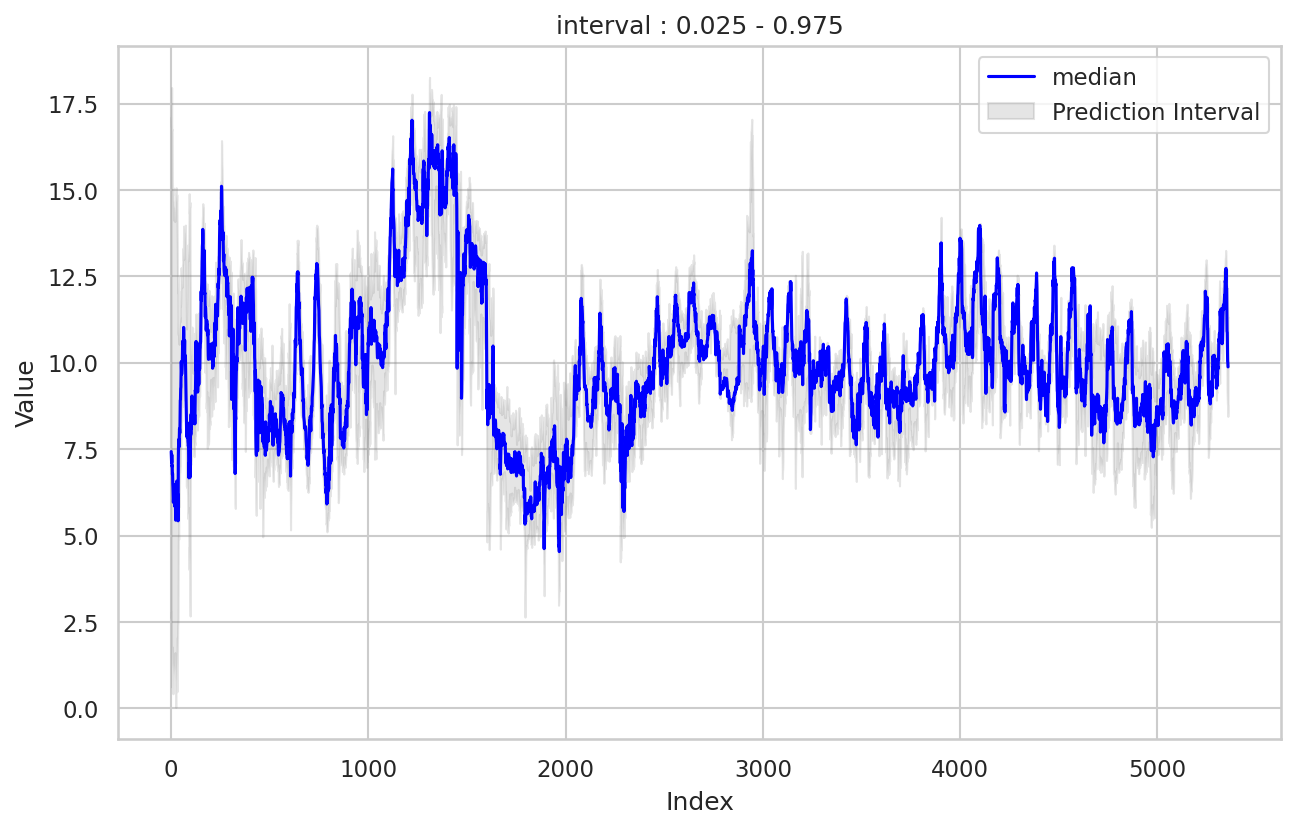

level : 90 interval : [0.05 , 0.95 ]



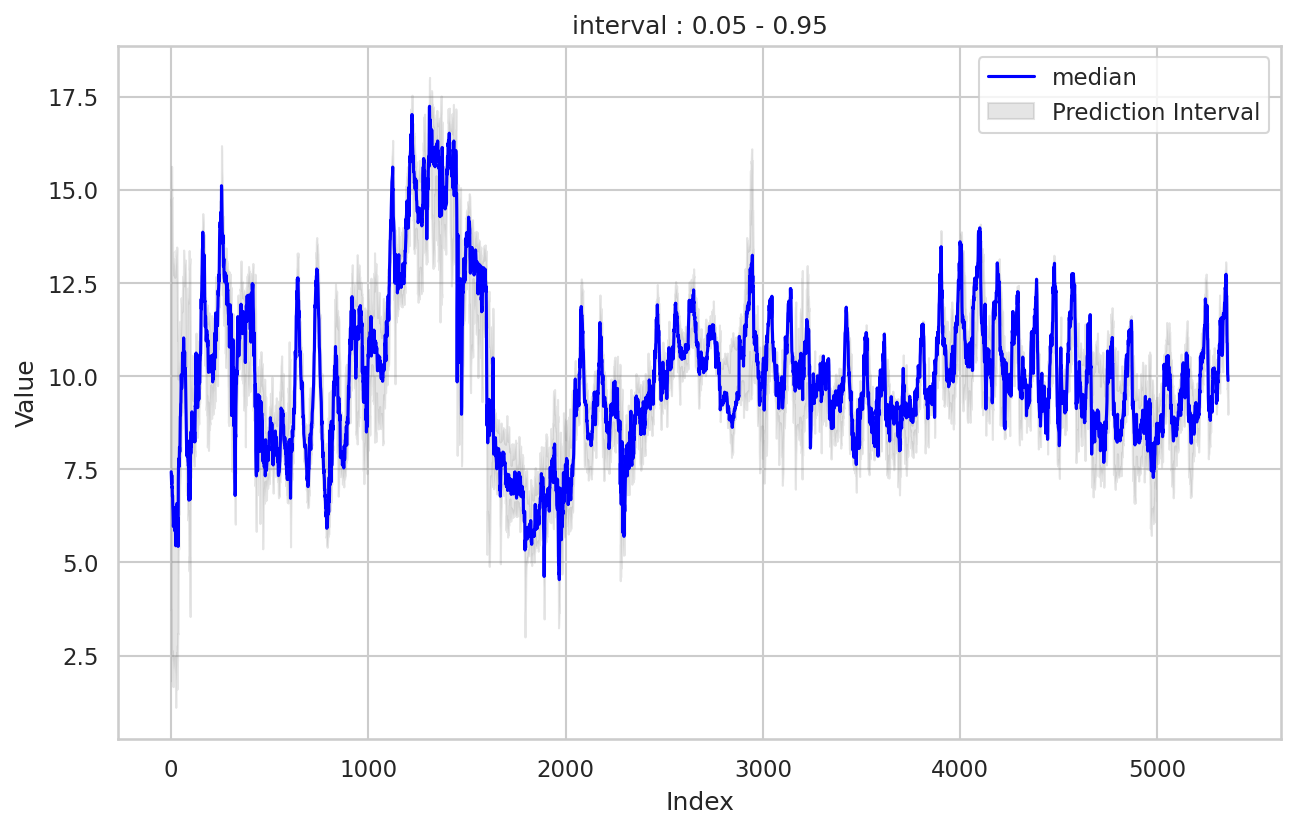

level : 80 interval : [0.10 , 0.90 ]



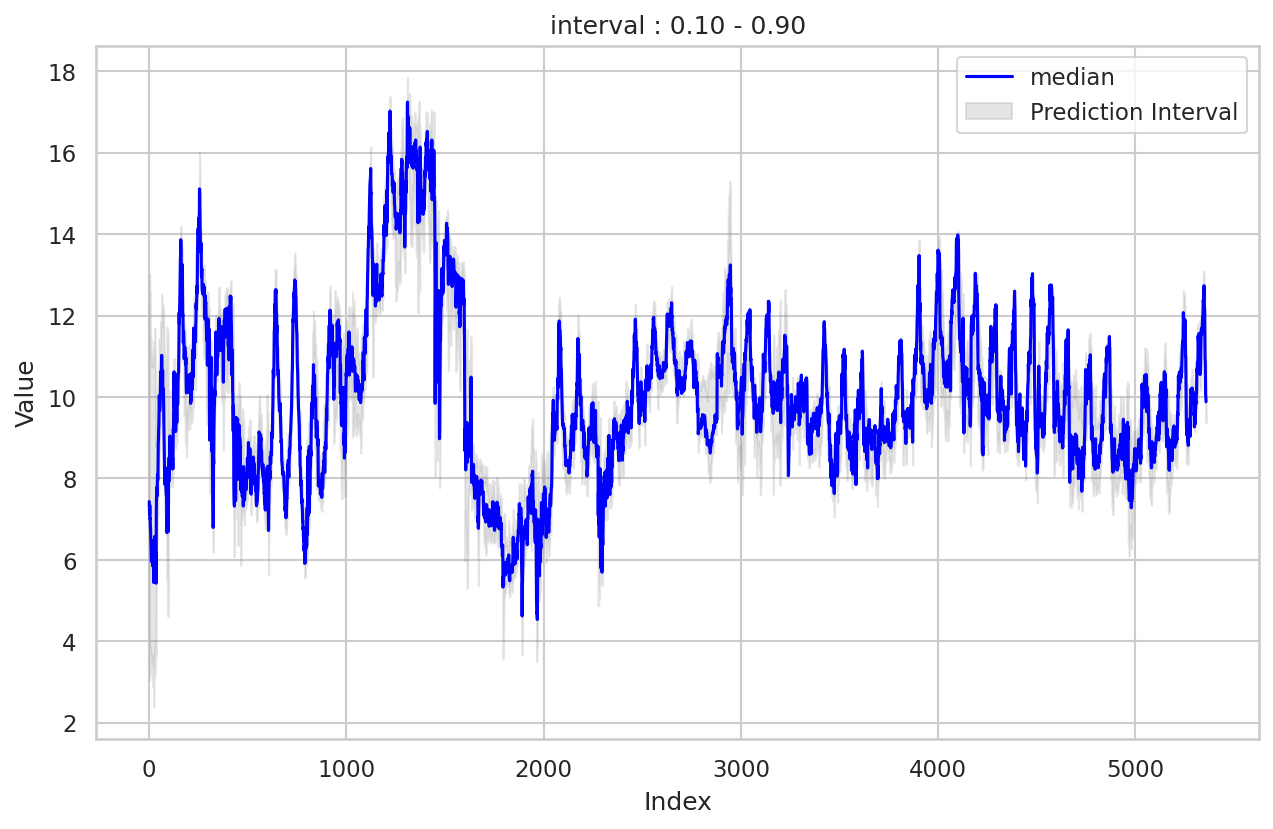

level : 70 interval : [0.15 , 0.85 ]



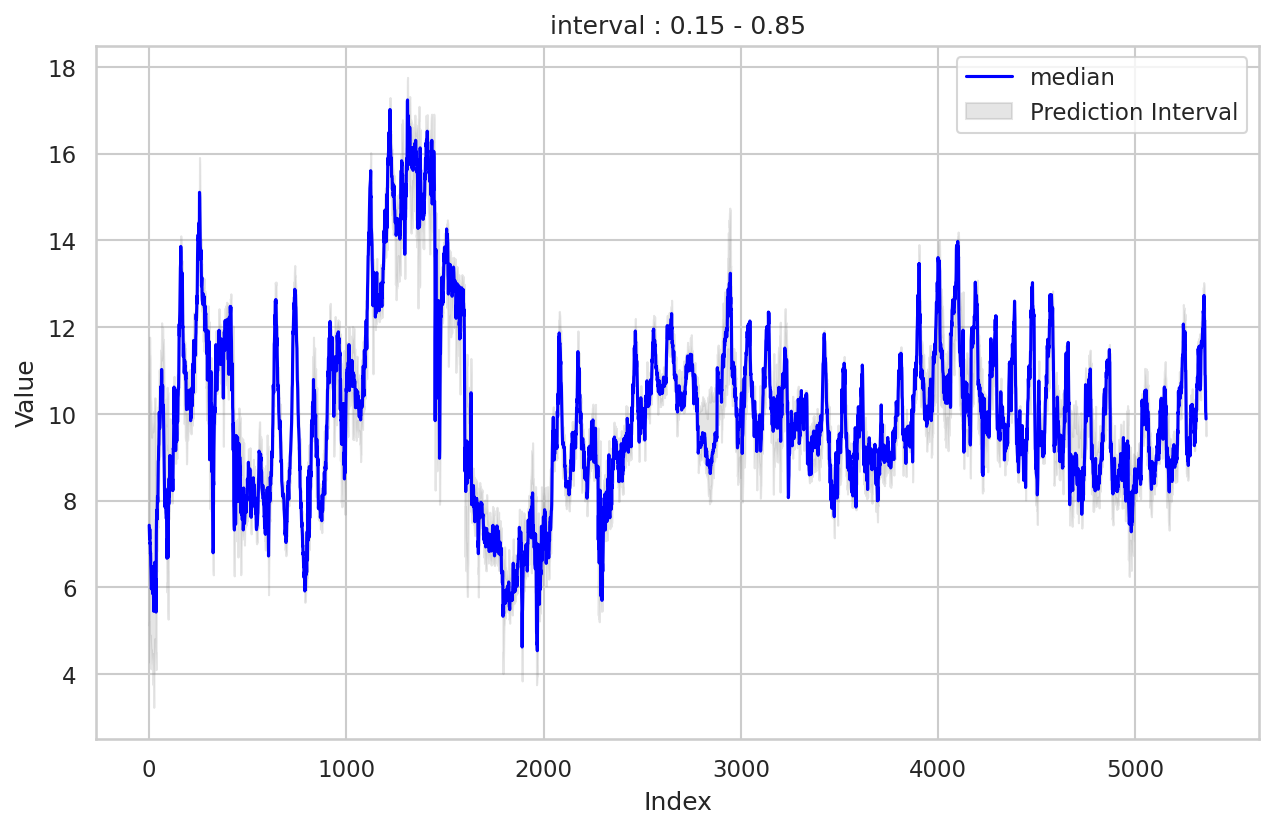

level : 60 interval : [0.20 , 0.80 ]



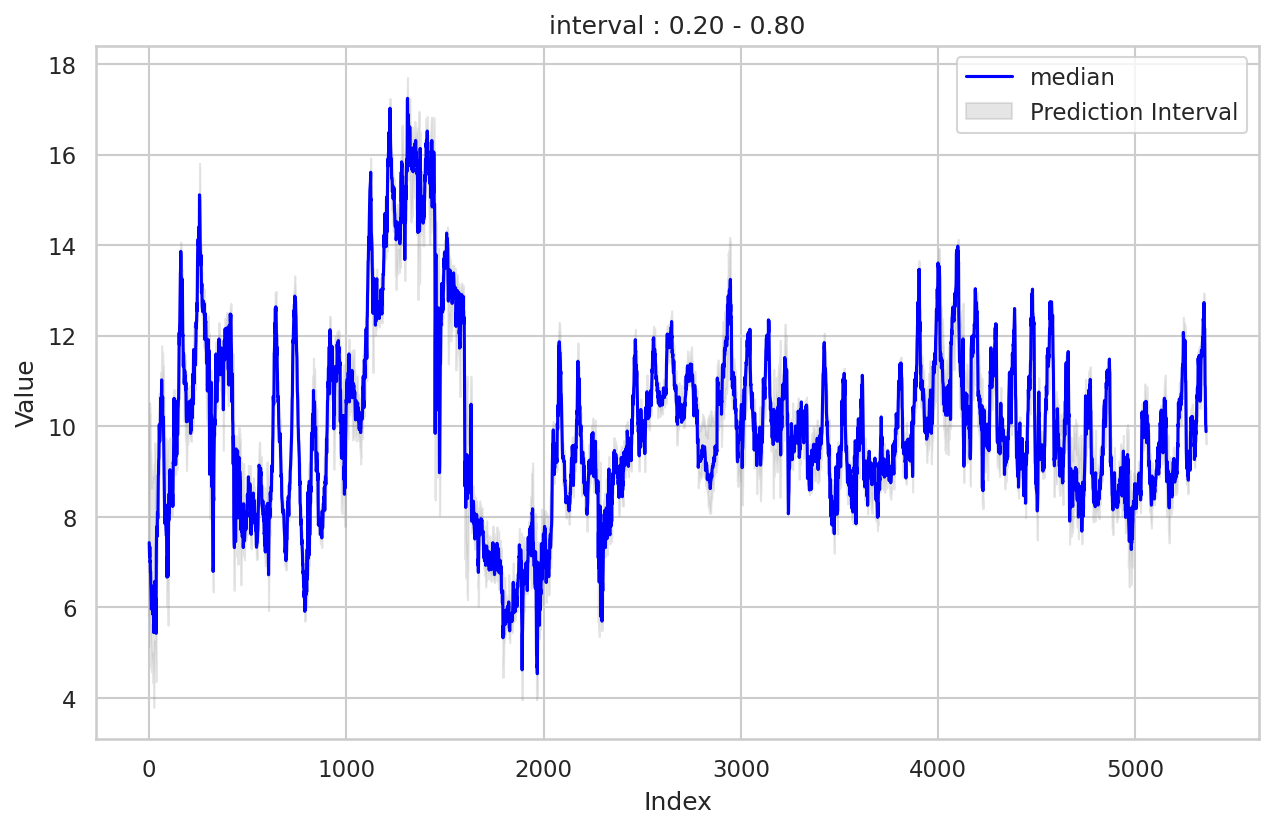

level : 50 interval : [0.25 , 0.75 ]



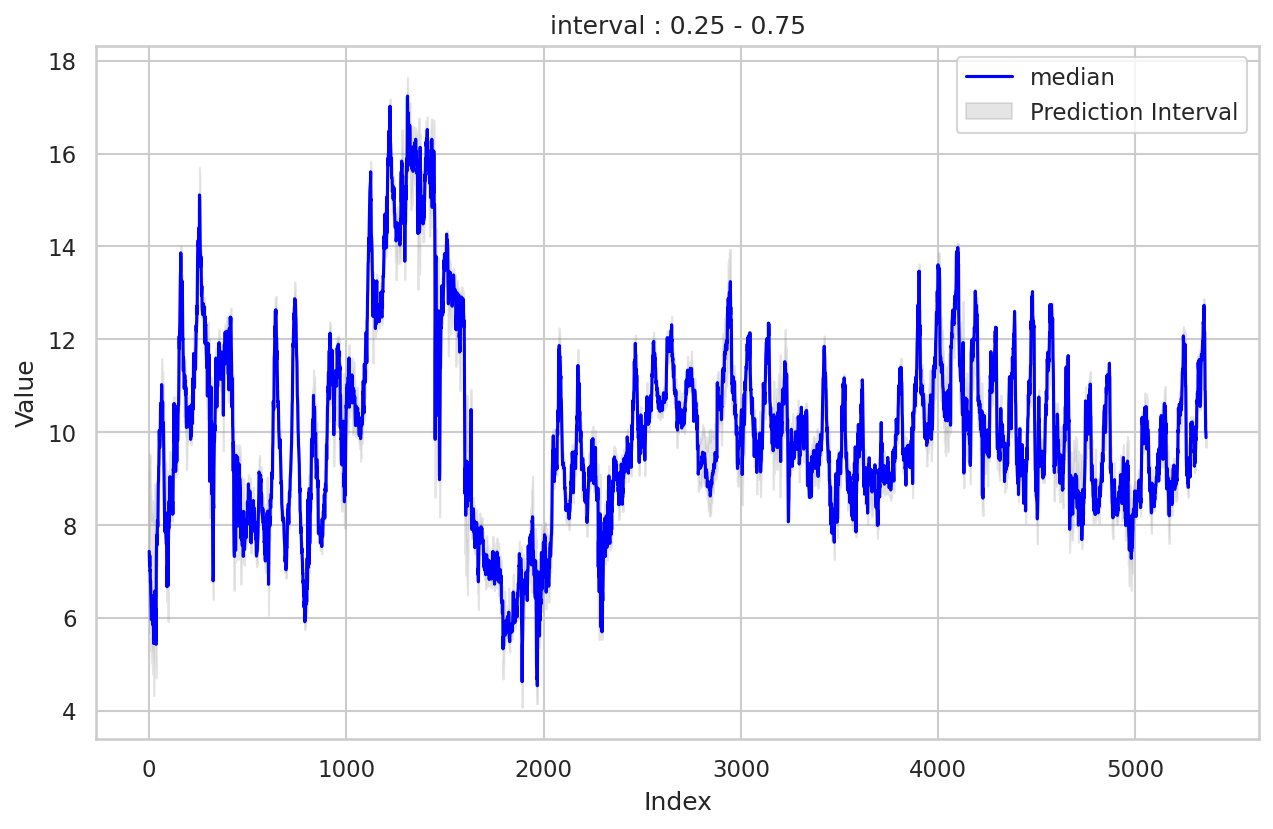

level : 40 interval : [0.30 , 0.70 ]



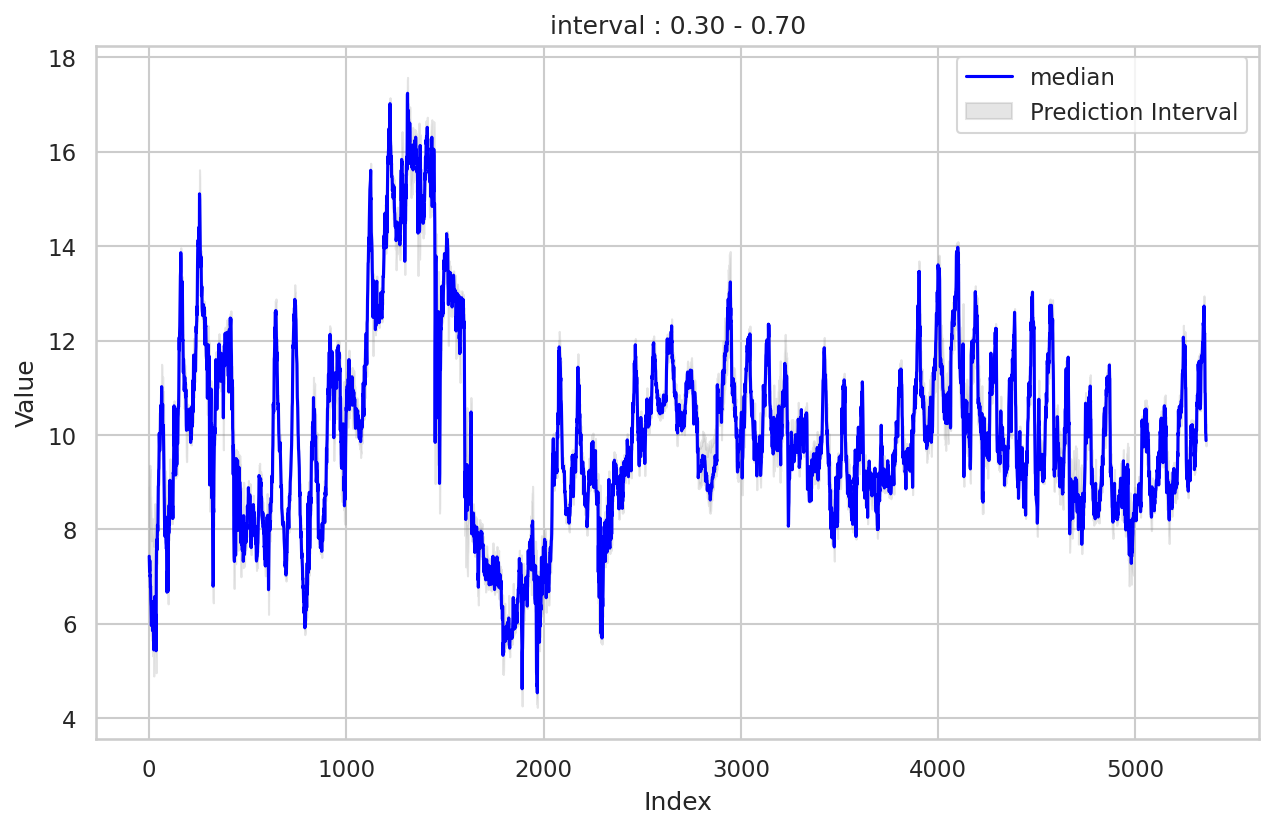

level : 30 interval : [0.35 , 0.65 ]



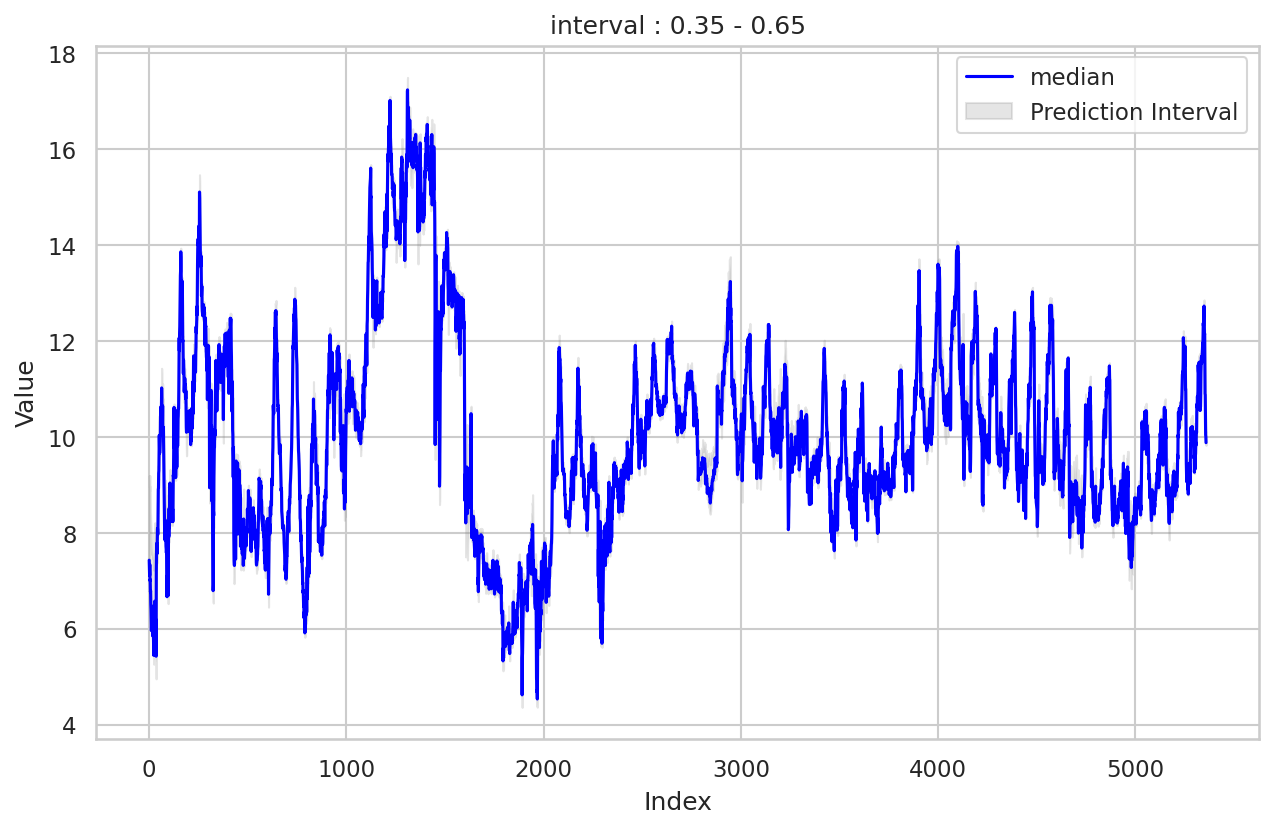

level : 20 interval : [0.40 , 0.60 ]



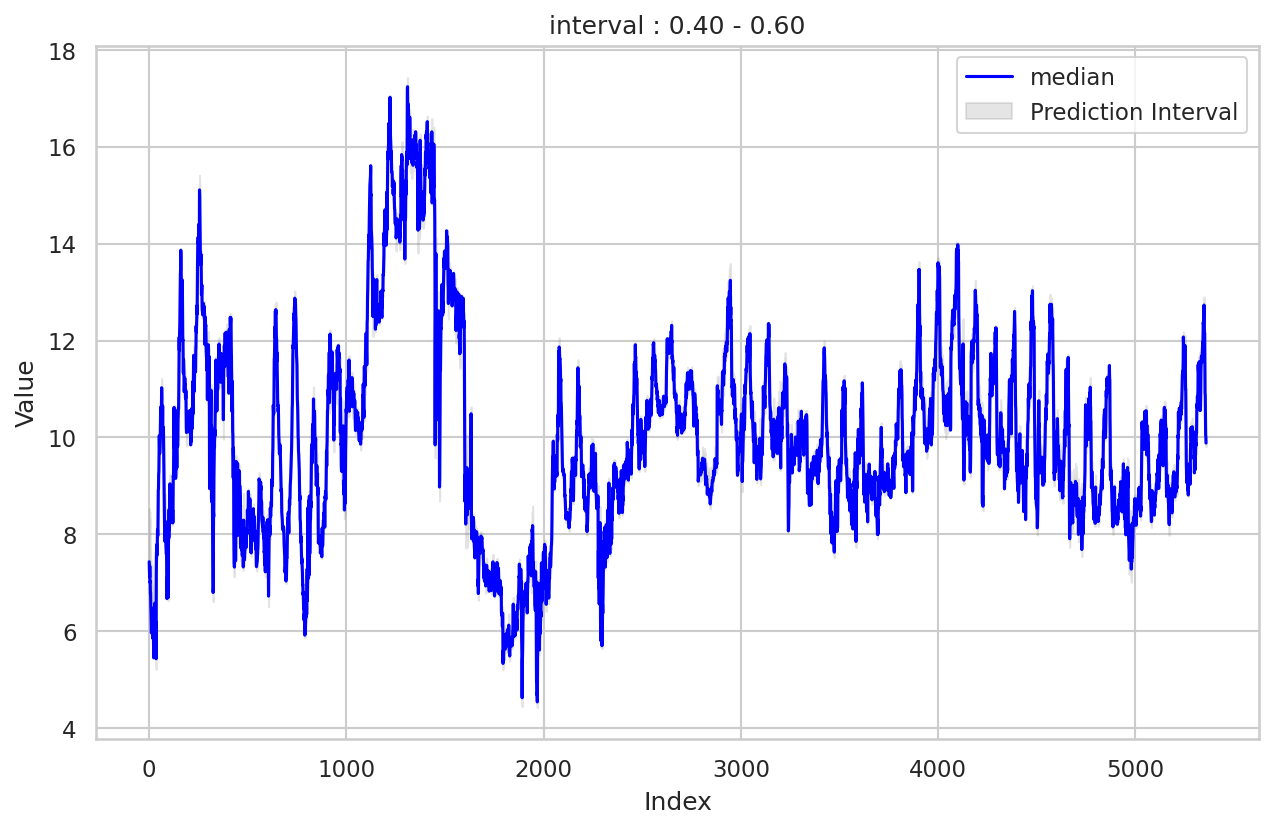

level : 10 interval : [0.45 , 0.55 ]



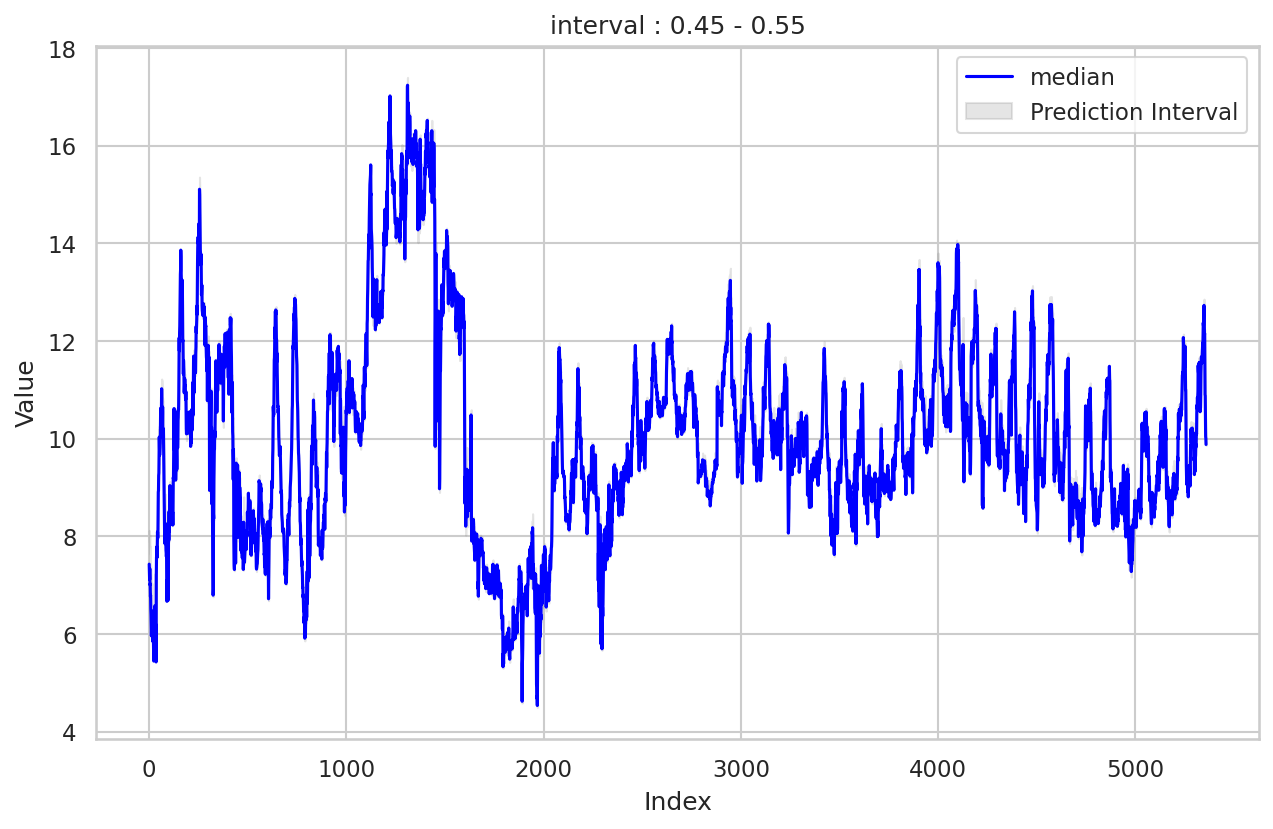

In [37]:
for (level, q_pair) in quantile_mapping.items():

    print(f'level : {level} interval : [{q_pair[0]} , {q_pair[1]} ]\n')
    
    title = 'interval : ' + q_pair[0] + ' - ' + q_pair[1]
    
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot actual values
    plt.plot(submission_df['0.50'], label='median', color='blue')


    # Plot prediction intervals
    plt.fill_between(submission_df.index, submission_df[q_pair[0]], submission_df[q_pair[1]],
                     color='gray', alpha=0.2, label='Prediction Interval')

    # Add the legend
    plt.legend()

    # Set labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)

    # Show the plot
    plt.show()

# E. Evaluation

In [38]:
# Dataframe with results
y_val = pd.DataFrame(y_val, columns=['Temperature'])
val_df = pd.concat([X_val, y_val], axis=1)

In [39]:
us.crps(submission_val_df, val_df)

0.4439417359203999

In [40]:
us.coverage_report(submission_val_df, val_df)

 Ideal: 95% Actual: 94.66% [FAIL] 
 Ideal: 90% Actual: 89.35% [FAIL] 
 Ideal: 80% Actual: 79.22% [FAIL] 
 Ideal: 70% Actual: 69.14% [FAIL] 
 Ideal: 60% Actual: 58.97% [FAIL] 
 Ideal: 50% Actual: 49.05% [FAIL] 
 Ideal: 40% Actual: 38.21% [FAIL] 
 Ideal: 30% Actual: 28.6% [FAIL] 
 Ideal: 20% Actual: 19.01% [FAIL] 
 Ideal: 10% Actual: 9.61% [FAIL] 


# F. Save Submission to file

In [41]:
submission_df.to_csv('submission.csv', index=False)

# End of code